In [1]:
!pip install gcm-filters -q

In [2]:
!pip install gsw -q

# Dask start

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35643")
client

<Client: 'tcp://127.0.0.1:35643' processes=4 threads=8, memory=29.40 GiB>

# Import

In [5]:
import sys
sys.path.insert(1, '../')

In [7]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import xesmf as xe
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
import xrft
#import seaborn as sns
from matplotlib.gridspec import GridSpec

# Load data

## eNATL60

Load Pangeo catalog

In [8]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [13]:
# x_slice = slice(400,700)
# y_slice = slice(500,800)

x_slice = slice(0,-1)
y_slice = slice(0,-1)

#resampling_avg_period = '96h'
data_slice = dict(time_counter=slice(0,-1,250),y=y_slice,x=x_slice)

coord_slice = dict(y=y_slice,x=x_slice)

In [14]:
nb_of_time_chunks = 7

In [15]:
%%time
dataSetsHR=[]

for region in ['1', '2', '3'] :
    for season in ['fma', 'aso'] :
        current_set = cat.eNATL60(region=region,datatype='surface_hourly', season=season).to_dask().\
        drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
        current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
        #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
        current_set = current_set.isel(data_slice)
        current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
        current_set.load()
        current_set['x'] = np.arange(len(current_set['x']))
        current_set['y'] = np.arange(len(current_set['y']))
        dataSetsHR.append({'region': region, 'season' : season, 'data': current_set, 'label' : 'HR'})

CPU times: user 1.28 s, sys: 381 ms, total: 1.67 s
Wall time: 1min 54s


In [16]:
selected_data_set = dataSetsHR[0]['data']

In [17]:
selected_data_set

<xarray.Dataset>
Dimensions:        (time_counter: 9, x: 610, y: 762)
Coordinates: (12/18)
    depth          (y, x) float32 819.0 813.6 813.6 ... 2.413e+03 2.434e+03
    e1f            (y, x) float64 1.605e+03 1.605e+03 ... 1.42e+03 1.42e+03
    e1t            (y, x) float64 1.605e+03 1.605e+03 ... 1.42e+03 1.42e+03
    e1u            (y, x) float64 1.605e+03 1.605e+03 ... 1.42e+03 1.42e+03
    e1v            (y, x) float64 1.605e+03 1.605e+03 ... 1.42e+03 1.42e+03
    e2f            (y, x) float64 1.564e+03 1.564e+03 ... 1.332e+03 1.332e+03
    ...             ...
    nav_lon        (y, x) float32 -78.01 -77.99 -77.97 ... -68.05 -68.04 -68.02
    time_centered  (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
    tmask          (y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 602 603 604 605 606 607 608 609
  * y              (y) int64 0 1 2 3 4 5 6 7 ... 754 755 756 757 758 759 760 761
Data variables:
    sosaline       (time_counter, y, x) float32 36.53 36.53 36.51 ... 36.29 36.3
    sosstsst       (time_counter, y, x) float32 22.26 22.29 22.3 ... 19.38 19.41

In [18]:
#selected_data_set.to_netcdf("Data/region"+dataSetsHR[i]['region']+"_"+dataSetsHR[i]['season']+".nc")

CPU times: user 1.27 s, sys: 36 ms, total: 1.31 s
Wall time: 1.3 s


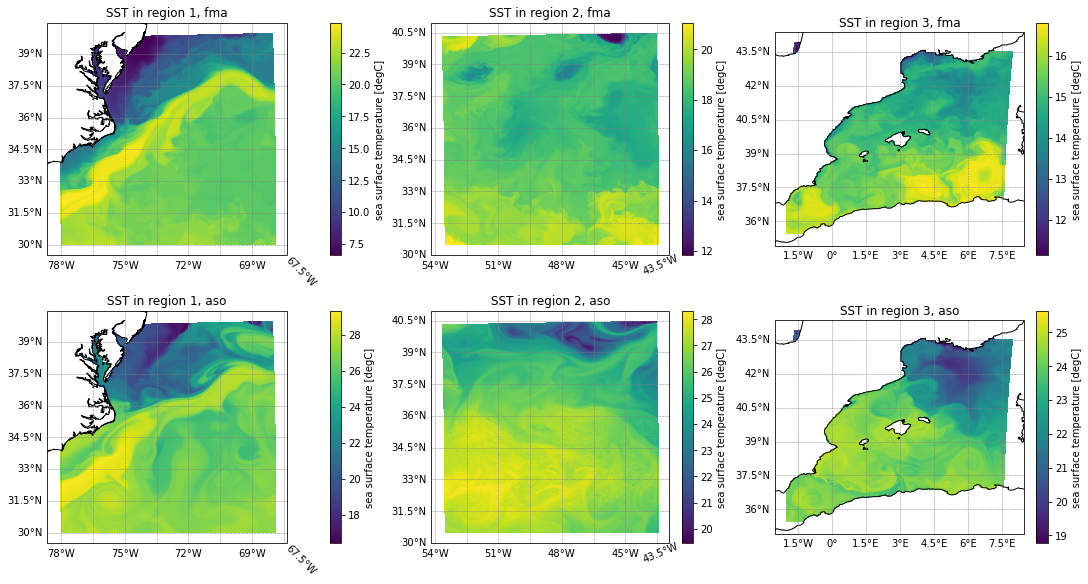

In [19]:
%%time
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()})
norm = colors.Normalize(vmin=6., vmax=29.)
for currentDataSet in dataSetsHR :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    currentDataSet['data'].isel(time_counter=0).sosstsst[coord_slice].plot(x='lon', y='lat', ax=ax[row,col])
    ax[row,col].set(title='SST in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
    ax[row,col].coastlines()
    gl = ax[row,col].gridlines(draw_labels=True, x_inline=False, y_inline=False, 
              color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False
#plt.savefig('Images/SST_vs_region_season.png')

CPU times: user 1.39 s, sys: 17.3 ms, total: 1.41 s
Wall time: 1.4 s


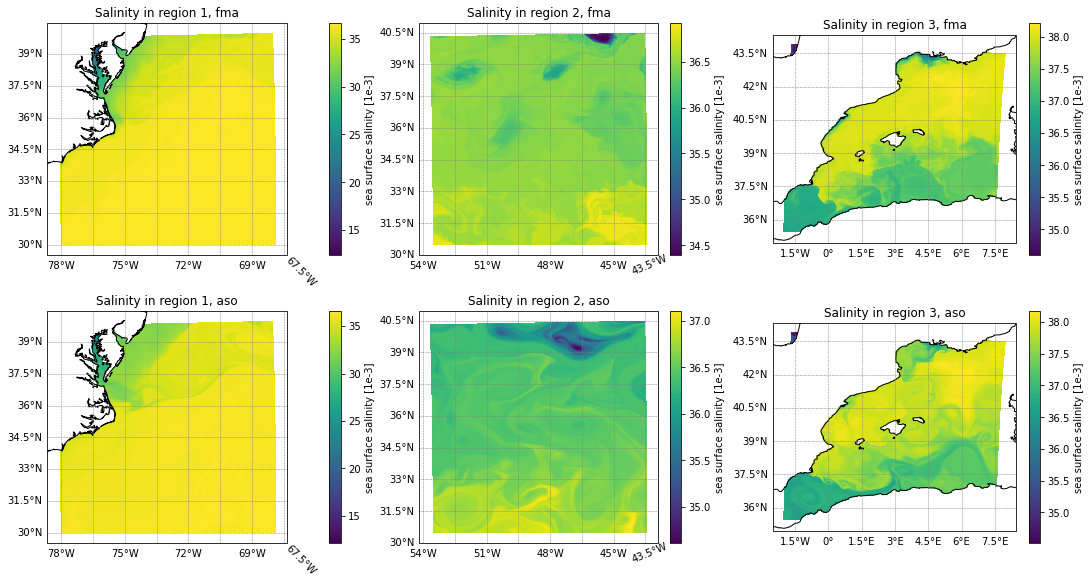

In [20]:
%%time
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()})
norm = colors.Normalize(vmin=6., vmax=29.)
for currentDataSet in dataSetsHR :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    currentDataSet['data'].isel(time_counter=0).sosaline[coord_slice].plot(x='lon', y='lat', ax=ax[row,col])
    ax[row,col].set(title='Salinity in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
    ax[row,col].coastlines()
    gl = ax[row,col].gridlines(draw_labels=True, x_inline=False, y_inline=False, 
              color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False
#plt.savefig('Images/Salinity_vs_region_season.png')

## eORCA025

In [22]:
dataSetsORCA25=[]

for region in ['1', '2', '3'] :
    for season in ['fma', 'aso'] :
        current_set = xr.open_dataset("../Data/eORCA025/region"+region+"_"+season+".nc", chunks={'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
        dataSetsORCA25.append({'region': region, 'season' : season, 'data': current_set,'label' : 'eORCA025'})

CPU times: user 383 ms, sys: 23.5 ms, total: 406 ms
Wall time: 587 ms


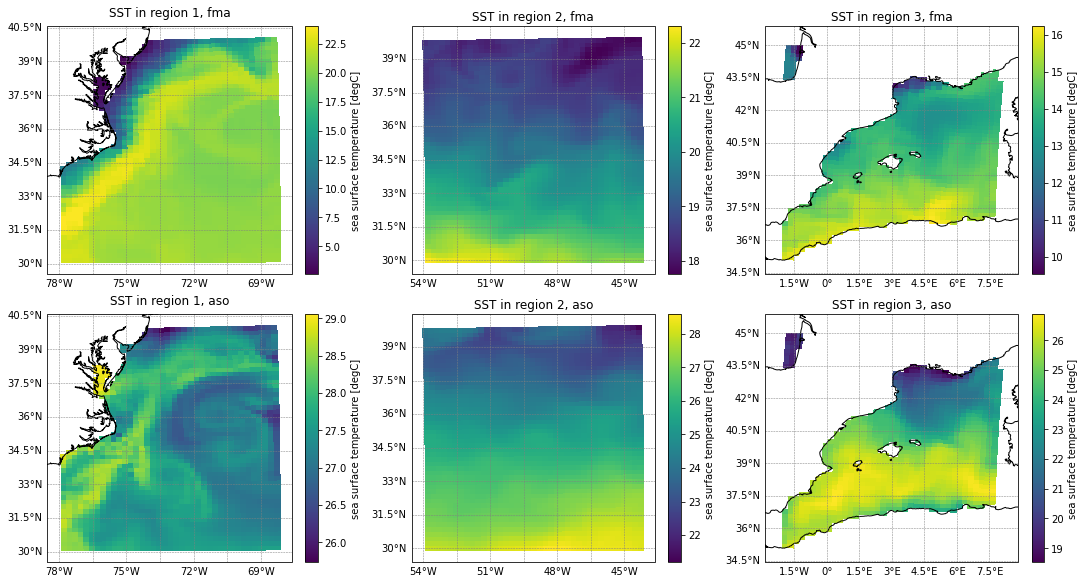

In [23]:
%%time
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()})
norm = colors.Normalize(vmin=6., vmax=29.)
for currentDataSet in dataSetsORCA25 :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    currentDataSet['data'].isel(time_counter=0).sosstsst[coord_slice].plot(x='nav_lon', y='nav_lat', ax=ax[row,col])
    ax[row,col].set(title='SST in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
    ax[row,col].coastlines()
    gl = ax[row,col].gridlines(draw_labels=True, x_inline=False, y_inline=False, 
              color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False
#plt.savefig('Images/Salinity_vs_region_season.png')

# Filter

Parameters (to determine) :

In [24]:
filter_coef = 32        #relative to the grid size
coarsening_window_size=12

In [25]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=False).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    new_e2t = data['e2t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=False).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    return result

In [26]:
def apply_filter_downsample(dataHR, filter_coef, coarse_window_size) :
    wet_mask = xr.DataArray(dataHR.tmask, dims=['y','x'])
    area = xr.DataArray((dataHR.e1t * dataHR.e2t), dims=['y','x'])
    if (filter_coef > 0) :
        # Filtering with a fixed factor
        dxw = xr.DataArray(dataHR.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(dataHR.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(dataHR.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(dataHR.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        dx_max = max(dxw.max(),dys.max()).values
        filter_scale = filter_coef*dx_max
#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
        kappa_w = dxw * dxw / (dx_max * dx_max)
        kappa_s = dys * dys / (dx_max * dx_max)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            filter_scale=filter_scale,    
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=dataHR.coords)
        data_filtered = gaussian_filter.apply(dataHR, dims=['y', 'x'])
    else :
        data_filtered = dataHR
    # spatial coarsening
    if (coarse_window_size > 0) :
        dataLR = downsample(data_filtered, coarse_window_size, area, wet_mask)
    else : 
        dataLR = data_filtered
    return dataLR

# Downgraded data

In [27]:
dataSetsLR = []

for dataHR in dataSetsHR :
    %time dataLR = apply_filter_downsample(dataHR['data'].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), \
                                           filter_coef, coarsening_window_size).compute().\
    chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    dataSetsLR.append({'region': dataHR['region'], 'season' : dataHR['season'], 'data': dataLR, 'label' : 'Coarse + Filter'})

CPU times: user 2.16 s, sys: 767 ms, total: 2.93 s
Wall time: 20.2 s
CPU times: user 2.15 s, sys: 793 ms, total: 2.94 s
Wall time: 19.8 s
CPU times: user 2.22 s, sys: 775 ms, total: 2.99 s
Wall time: 16 s
CPU times: user 2.04 s, sys: 740 ms, total: 2.78 s
Wall time: 15.1 s
CPU times: user 2 s, sys: 729 ms, total: 2.73 s
Wall time: 14.1 s
CPU times: user 1.97 s, sys: 746 ms, total: 2.72 s
Wall time: 13.9 s


In [28]:
dataSetsCoarse = []

for dataHR in dataSetsHR :
    %time dataCoarse = apply_filter_downsample(dataHR['data'], 0, coarsening_window_size).compute().\
    chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    dataSetsCoarse.append({'region': dataHR['region'], 'season' : dataHR['season'], 'data': dataCoarse, 'label' : 'Coarse'})

CPU times: user 270 ms, sys: 21 ms, total: 291 ms
Wall time: 287 ms
CPU times: user 255 ms, sys: 23.8 ms, total: 279 ms
Wall time: 278 ms
CPU times: user 257 ms, sys: 0 ns, total: 257 ms
Wall time: 257 ms
CPU times: user 256 ms, sys: 1.31 ms, total: 257 ms
Wall time: 256 ms
CPU times: user 227 ms, sys: 0 ns, total: 227 ms
Wall time: 226 ms
CPU times: user 229 ms, sys: 0 ns, total: 229 ms
Wall time: 228 ms


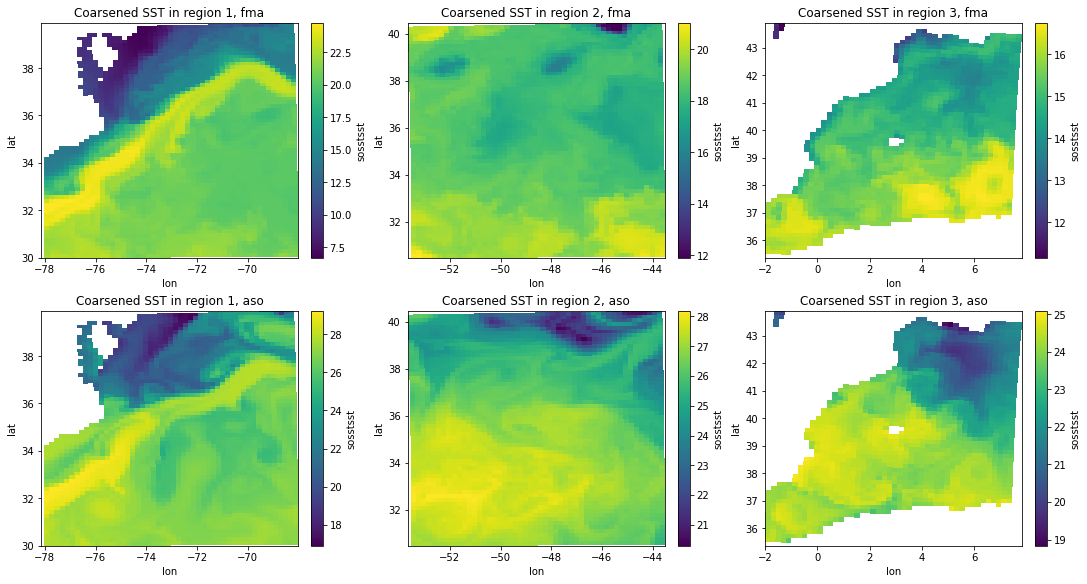

In [29]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
norm = colors.Normalize(vmin=6., vmax=29.)
for currentDataSet in dataSetsCoarse :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    currentDataSet['data'].isel(time_counter=0).sosstsst.plot(x='lon', y='lat', ax=ax[row,col])
    ax[row,col].set(title='Coarsened SST in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
#plt.savefig('Images/SST_filtered_downsampled_vs_region_season.png')

In [30]:
x_slice = slice(0,-1)
y_slice = slice(2,-1)

bord_cut = dict(y=y_slice,x=x_slice)

In [31]:
# %%time
# fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
# for currentDataSet in dataSetsHR :
#     col = int(currentDataSet['region'])-1
#     if (currentDataSet['season'] == 'aso') : row=1
#     if (currentDataSet['season'] == 'fma') : row=0
#     apply_filter_downsample(currentDataSet['data'].isel(time_counter=0).sosstsst, 32, coarsening_window_size).\
#     plot(x='lon', y='lat', ax=ax[row,col])

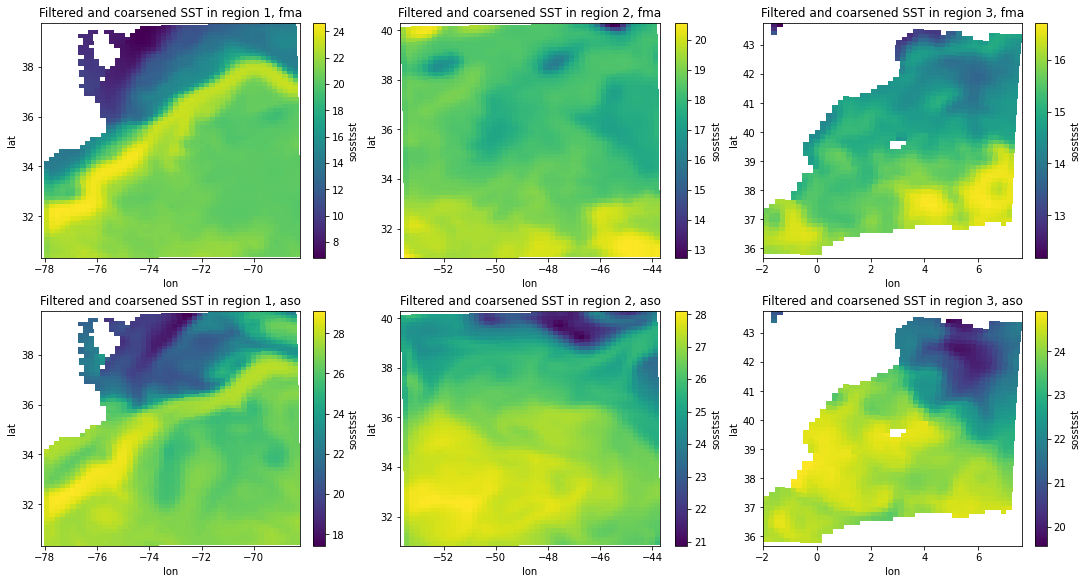

In [32]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
norm = colors.Normalize(vmin=6., vmax=29.)
for currentDataSet in dataSetsLR :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    currentDataSet['data'].isel(time_counter=0).sosstsst[bord_cut].plot(x='lon', y='lat', ax=ax[row,col])
    ax[row,col].set(title='Filtered and coarsened SST in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
#plt.savefig('Images/SST_filtered_downsampled_vs_region_season.png')

In [33]:
# fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
# norm = colors.Normalize(vmin=6., vmax=29.)
# for currentDataSet in dataSetsLR :
#     col = int(currentDataSet['region'])-1
#     if (currentDataSet['season'] == 'aso') : row=1
#     if (currentDataSet['season'] == 'fma') : row=0
#     currentDataSet['data'].e1t[bord_cut].plot(x='lon', y='lat', ax=ax[row,col])
#     ax[row,col].set(title='Filtered and coarsened SST in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
# #plt.savefig('Images/SST_filtered_downsampled_vs_region_season.png')

# Histograms of salinity and SST

In [34]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
        bins2 = np.linspace(dataSet[var2].min(), dataSet[var2].max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t).where(dataSet.tmask >0), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum()).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), dataSet[var2].fillna(0), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = hist/hist.sum()
    return norm_hist

In [35]:
nb_of_bins = 150

In [36]:
%%time
for currentDataSet in (dataSetsLR+dataSetsCoarse+dataSetsORCA25) :
    currentDataSet['histogram_temp_sal'] = compute_2D_histogram(currentDataSet['data'][bord_cut], 'sosaline', 'sosstsst', nb_of_bins).compute()

CPU times: user 1.64 s, sys: 60.1 ms, total: 1.7 s
Wall time: 6.62 s


In [37]:
for currentDataSet in dataSetsHR :
    %time currentDataSet['histogram_temp_sal'] = compute_2D_histogram(currentDataSet['data'].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), \
                                                                      'sosaline', 'sosstsst', nb_of_bins).compute()

CPU times: user 254 ms, sys: 38.1 ms, total: 292 ms
Wall time: 646 ms
CPU times: user 264 ms, sys: 31 ms, total: 295 ms
Wall time: 685 ms
CPU times: user 202 ms, sys: 37.3 ms, total: 239 ms
Wall time: 649 ms
CPU times: user 193 ms, sys: 32.2 ms, total: 226 ms
Wall time: 631 ms
CPU times: user 262 ms, sys: 16.2 ms, total: 278 ms
Wall time: 593 ms
CPU times: user 267 ms, sys: 9.43 ms, total: 277 ms
Wall time: 585 ms


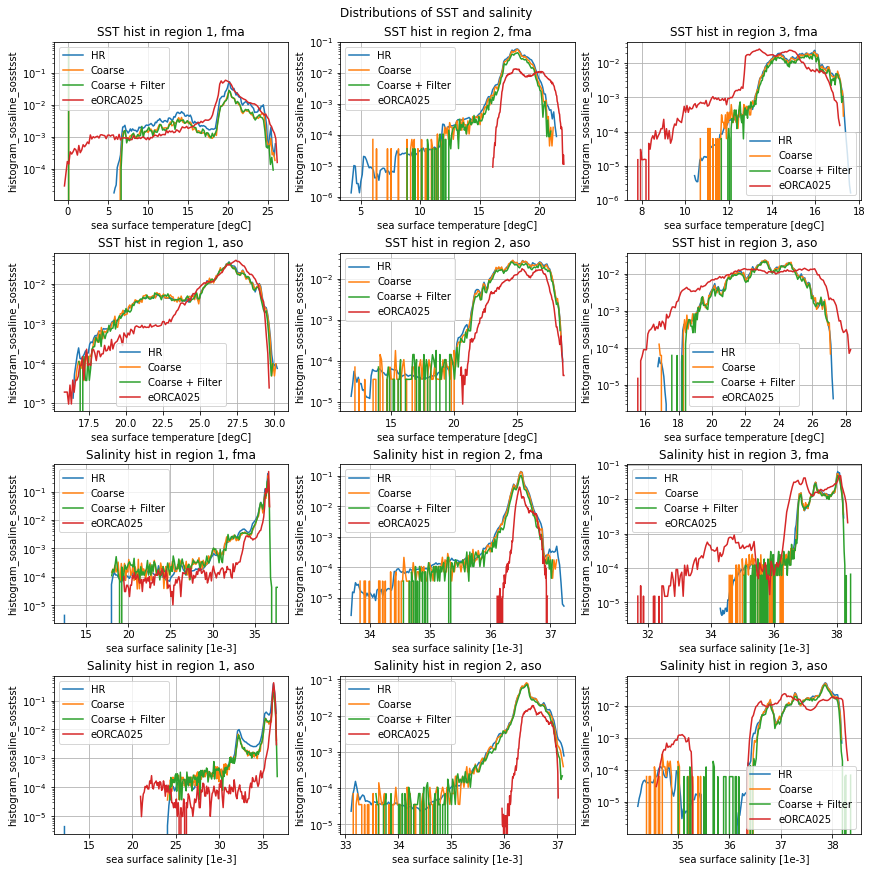

In [38]:
fig, ax = plt.subplots(ncols=3, nrows=4, constrained_layout=True, figsize=(12,12))
fig.suptitle('Distributions of SST and salinity')
for i in range(len(dataSetsLR)) :
    # temperature PDFs
    col = int(dataSetsLR[i]['region'])-1
    if (dataSetsLR[i]['season'] == 'aso') : row=1
    if (dataSetsLR[i]['season'] == 'fma') : row=0
    for dataSet in [dataSetsHR, dataSetsCoarse, dataSetsLR, dataSetsORCA25] :
        hist_temp = dataSet[i]['histogram_temp_sal'].sum(dim='sosaline_bin')
        hist_temp.plot(ax=ax[row,col], label=dataSet[i]['label'])
    ax[row,col].set(yscale='log',title='SST hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)
    # salinity PDFs
    if (dataSetsLR[i]['season'] == 'aso') : row=3
    if (dataSetsLR[i]['season'] == 'fma') : row=2
    for dataSet in [dataSetsHR, dataSetsCoarse, dataSetsLR, dataSetsORCA25] :
        hist_temp = dataSet[i]['histogram_temp_sal'].sum(dim='sosstsst_bin')
        hist_temp.plot(ax=ax[row,col], label=dataSet[i]['label'])
    ax[row,col].set(yscale='log',title='Salinity hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)

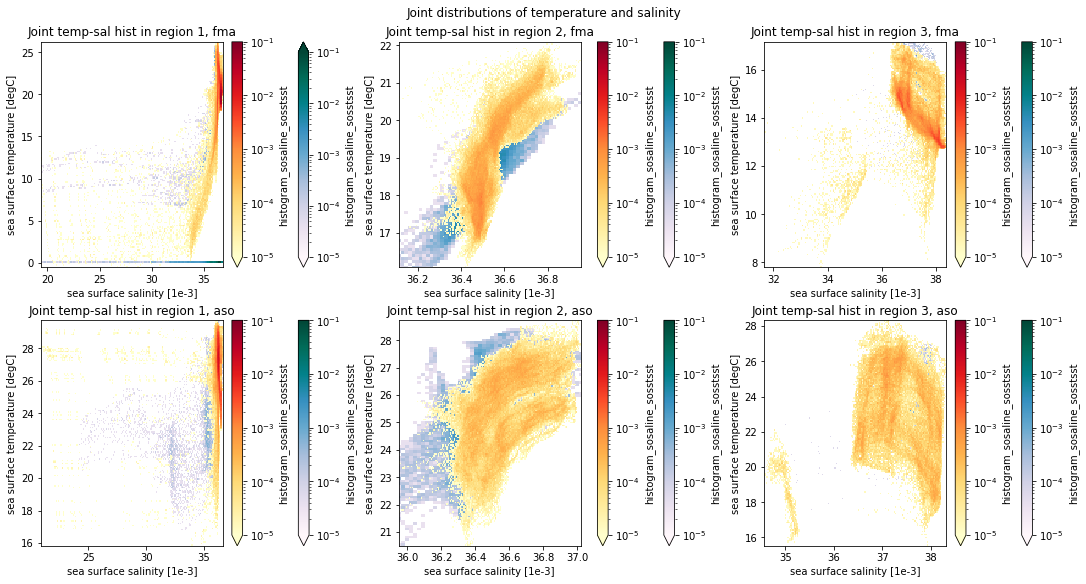

In [39]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
fig.suptitle('Joint distributions of temperature and salinity')
for i,currentDataSet in enumerate(dataSetsLR) :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    dataSetsLR[i]['histogram_temp_sal'].plot(x='sosaline_bin', y='sosstsst_bin', ax=ax[row,col], label='HR',norm=colors.LogNorm(vmin=1e-5, vmax=0.1), cmap='PuBuGn')
    dataSetsORCA25[i]['histogram_temp_sal'].plot(x='sosaline_bin', y='sosstsst_bin', ax=ax[row,col], label='eORCA025',norm=colors.LogNorm(vmin=1e-5, vmax=0.1), cmap='YlOrRd')
    ax[row,col].set(title='Joint temp-sal hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    #ax[row,col].legend()

In [40]:
# da_stacked = dataSetsLR[0]['data'].where(dataSetsLR[0]['data']['tmask']==1, drop=True).\
# drop(['time_counter','time_centered', 'tmask','x','y','depth','e1f','e1t','e1u','e1v','e2f','e2t','e2u','e2v','lat','lon','nav_lat','nav_lon'],errors='ignore').\
# stack(z=("x", "y", "time_counter"))

In [41]:
min_hist = 1e-5
max_hist = 0.5
log_norm=colors.LogNorm(vmin=min_hist, vmax=max_hist)

def margin_hist(data, cmap, x_bins, y_bins, ax_histx, ax_histy, ax_big):
    hist_joint = ax_big.pcolormesh(data[x_bins],data[y_bins], data.T, norm=log_norm, cmap=cmap, shading='auto', alpha=0.95)
    
    margin_hist_x = data.sum(dim=y_bins)
    ax_histx.plot(data[x_bins],margin_hist_x)
    ax_histx.set(yscale='log', ylim=[min_hist, max_hist])
    ax_histx.tick_params(labelleft=False, labelbottom=False)    
    
    margin_hist_y = data.sum(dim=x_bins)
    ax_histy.plot(margin_hist_y,data[y_bins])
    ax_histy.set(xscale='log', xlim=[min_hist, max_hist])
    ax_histy.tick_params(labelleft=False, labelbottom=False)     
    
    return hist_joint

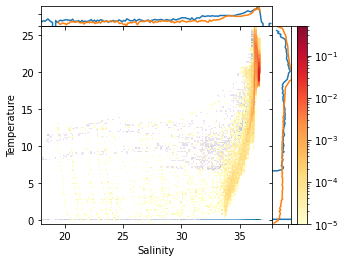

In [42]:
sel_data = dataSetsLR[0]['histogram_temp_sal']
sel_data2 = dataSetsORCA25[0]['histogram_temp_sal']

fig = plt.figure(figsize=(5,4))
gs = GridSpec(2, 3, width_ratios=[10, 1.1, 1], height_ratios=[1, 10], wspace=0, hspace=0)
big_ax = fig.add_subplot(gs[1,0]) # bottom left
top_ax = fig.add_subplot(gs[0,0], sharex=big_ax) # top left
right_ax = fig.add_subplot(gs[1,1], sharey=big_ax) # bottom center
cbar_ax = fig.add_subplot(gs[1,2]) # bottom right
cbar_ax.set(xticks=[], yticks=[])

margin_hist(sel_data,'PuBuGn', 'sosaline_bin', 'sosstsst_bin', top_ax, right_ax, big_ax)
hist_joint = margin_hist(sel_data2, 'YlOrRd', 'sosaline_bin', 'sosstsst_bin', top_ax, right_ax, big_ax)
#hist1 = big_ax.pcolormesh(sel_data['sosaline_bin'],sel_data['sosstsst_bin'], sel_data.T, norm=log_norm, cmap='PuBuGn', shading='auto', alpha=0.95)
#hist1 = big_ax.pcolormesh(sel_data2['sosaline_bin'],sel_data2['sosstsst_bin'], sel_data2.T, norm=log_norm, cmap='YlOrRd', shading='auto', alpha=0.95)
big_ax.set(xlabel='Salinity', ylabel='Temperature')
fig.colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

plt.show()

# Histograms of gradients

## Compute gradients

In [43]:
def gradx(dataArray, delta_x) :
    return (dataArray.shift(x=-1) - dataArray)/delta_x
def grady(dataArray, delta_y) :
    return (dataArray.shift(y=-1) - dataArray)/delta_y

In [44]:
def diffx(dataArray) :
    return (dataArray.shift(x=-1) - dataArray)
def diffy(dataArray) :
    return (dataArray.shift(y=-1) - dataArray)

In [45]:
def add_spatial_grad_to_dataset(input_dataset) :
    return xr.merge([input_dataset,
                      xr.DataArray(gradx(input_dataset.sosstsst, input_dataset.e1t), name='gradx_temp'),
                      xr.DataArray(grady(input_dataset.sosstsst, input_dataset.e2t), name='grady_temp'),
                      xr.DataArray(gradx(input_dataset.sosaline, input_dataset.e1t), name='gradx_sal'),
                      xr.DataArray(grady(input_dataset.sosaline, input_dataset.e2t), name='grady_sal'),                      
                      xr.DataArray(np.sqrt(gradx(input_dataset.sosstsst, input_dataset.e1t)**2+\
                                          grady(input_dataset.sosstsst, input_dataset.e2t)**2), name='grad_temp'),
                      xr.DataArray(np.sqrt(gradx(input_dataset.sosaline, input_dataset.e1t)**2+\
                                          grady(input_dataset.sosaline, input_dataset.e2t)**2), name='grad_sal')],compat='override')

In [46]:
%%time
for currentDataSet in (dataSetsLR+dataSetsHR+dataSetsCoarse) :
    currentDataSet['data'] = add_spatial_grad_to_dataset(currentDataSet['data']).compute().chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})

CPU times: user 5.75 s, sys: 985 ms, total: 6.73 s
Wall time: 9.48 s


In [47]:
%%time
for currentDataSet in dataSetsCoarse :
    currentDataSet['hist_grads'] = compute_2D_histogram(currentDataSet['data'], 'grad_sal', 'grad_temp', nb_of_bins).compute()
    #dataSetsLR[i]['hist_grads'].to_netcdf("Data/Compare_histograms/filter_30km_coarse_12_hist_grad_sal_temp_LR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")
for i in range(len(dataSetsLR)) :
    dataSetsHR[i]['hist_grads'] = compute_2D_histogram(dataSetsHR[i]['data'], 'grad_sal', 'grad_temp', nb_of_bins,\
                                                       bins=[dataSetsCoarse[i]['hist_grads'].grad_sal_bin.values,dataSetsCoarse[i]['hist_grads'].grad_temp_bin.values]).compute()
    dataSetsLR[i]['hist_grads'] = compute_2D_histogram(dataSetsLR[i]['data'][bord_cut], 'grad_sal', 'grad_temp', nb_of_bins,\
                                                       bins=[dataSetsCoarse[i]['hist_grads'].grad_sal_bin.values,dataSetsCoarse[i]['hist_grads'].grad_temp_bin.values]).compute()
    dataSetsORCA25[i]['hist_grads'] = compute_2D_histogram(dataSetsORCA25[i]['data'], 'grad_sal', 'grad_temp', nb_of_bins,\
                                                       bins=[dataSetsCoarse[i]['hist_grads'].grad_sal_bin.values,dataSetsCoarse[i]['hist_grads'].grad_temp_bin.values]).compute()    
    #dataSetsHR[i]['hist_grads'].to_netcdf("Data/Compare_histograms/hist_grad_sal_temp_HR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")
    #dataSetsHR[i]['hist_grads'].to_netcdf("Data/Compare_histograms/coarse_12_hist_grad_sal_temp_LR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")

CPU times: user 1.62 s, sys: 175 ms, total: 1.8 s
Wall time: 6.45 s


## Norms of 2d gradients

Plot histograms for spatial gradients of SST:
$$\partial_x T \approx \frac{T_{i+1, j} - T_{i, j}}{e1t} $$
$$\partial_y T \approx \frac{T_{i, j+1} - T_{i, j}}{e2t} $$
$$ |\textrm{grad}~T| = \sqrt{\partial_x T^2 + \partial_y T^2} $$

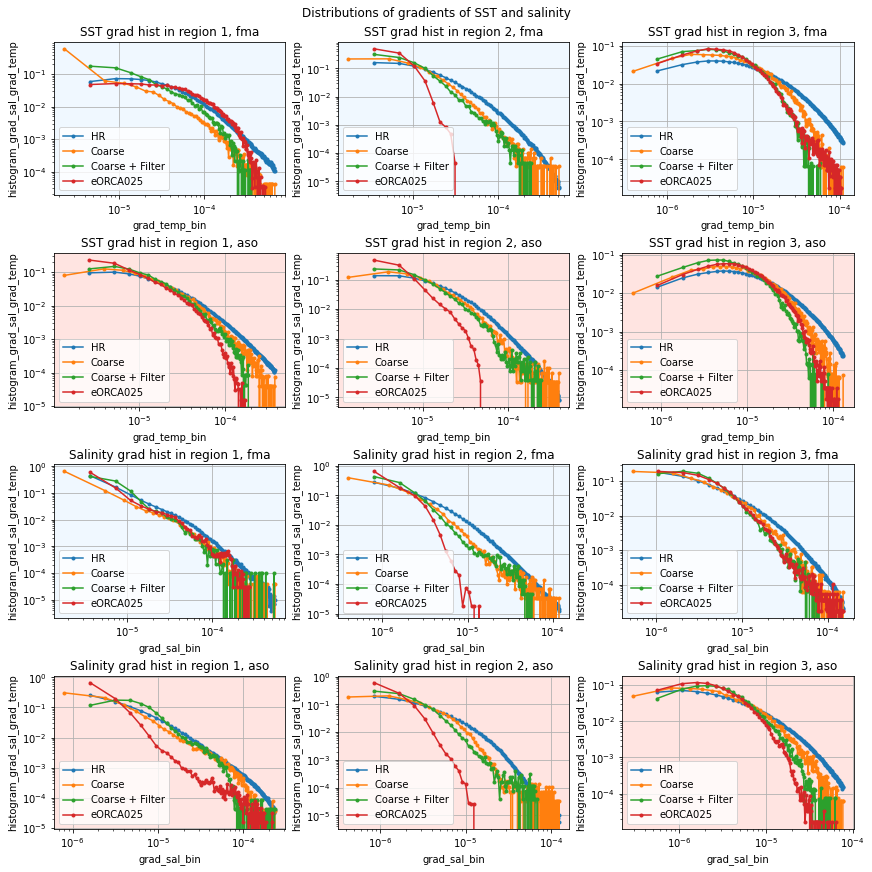

In [48]:
fig, ax = plt.subplots(ncols=3, nrows=4, constrained_layout=True, figsize=(12,12))
fig.suptitle('Distributions of gradients of SST and salinity')
for i in range(len(dataSetsLR)) :
    # temperature PDFs
    col = int(dataSetsLR[i]['region'])-1
    if (dataSetsLR[i]['season'] == 'aso') : 
        row=1; ax[row,col].set_facecolor('mistyrose')
    if (dataSetsLR[i]['season'] == 'fma') : 
        row=0; ax[row,col].set_facecolor('aliceblue')
    for dataSet in [dataSetsHR, dataSetsCoarse, dataSetsLR, dataSetsORCA25] :
        dataSet[i]['hist_grads'].sum(dim='grad_sal_bin').plot(ax=ax[row,col], label=dataSet[i]['label'], ls='-', marker='.')
    ax[row,col].set(yscale='log', xscale='log', title='SST grad hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)
    # salinity PDFs
    if (dataSetsLR[i]['season'] == 'aso') : 
        row=3; ax[row,col].set_facecolor('mistyrose')
    if (dataSetsLR[i]['season'] == 'fma') : 
        row=2; ax[row,col].set_facecolor('aliceblue')
    for dataSet in [dataSetsHR, dataSetsCoarse, dataSetsLR, dataSetsORCA25] :
        dataSet[i]['hist_grads'].sum(dim='grad_temp_bin').plot(ax=ax[row,col], label=dataSet[i]['label'], ls='-', marker='.')
    ax[row,col].set(yscale='log', xscale='log', title='Salinity grad hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)

## X-direction gradients

In [49]:
%%time
for i in range(len(dataSetsLR)) :
    dataSetsCoarse[i]['hist_grads_x'] = compute_2D_histogram(dataSetsCoarse[i]['data'][bord_cut], 'gradx_sal', 'gradx_temp', nb_of_bins).compute()
    #dataSetsLR[i]['hist_grads'].to_netcdf("Data/Compare_histograms/filter_30km_coarse_12_hist_grad_sal_temp_LR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")
for i in range(len(dataSetsLR)) :
    dataSetsHR[i]['hist_grads_x'] = compute_2D_histogram(dataSetsHR[i]['data'], 'gradx_sal', 'gradx_temp', nb_of_bins,\
                                                       bins=[dataSetsCoarse[i]['hist_grads_x'].gradx_sal_bin.values,dataSetsCoarse[i]['hist_grads_x'].gradx_temp_bin.values]).compute()
    dataSetsLR[i]['hist_grads_x'] = compute_2D_histogram(dataSetsLR[i]['data'], 'gradx_sal', 'gradx_temp', nb_of_bins,\
                                                       bins=[dataSetsCoarse[i]['hist_grads_x'].gradx_sal_bin.values,dataSetsCoarse[i]['hist_grads_x'].gradx_temp_bin.values]).compute()
    dataSetsORCA25[i]['hist_grads_x'] = compute_2D_histogram(dataSetsORCA25[i]['data'], 'gradx_sal', 'gradx_temp', nb_of_bins,\
                                                       bins=[dataSetsCoarse[i]['hist_grads_x'].gradx_sal_bin.values,dataSetsCoarse[i]['hist_grads_x'].gradx_temp_bin.values]).compute()
    #dataSetsHR[i]['hist_grads'].to_netcdf("Data/Compare_histograms/hist_grad_sal_temp_HR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")
    #dataSetsHR[i]['hist_grads'].to_netcdf("Data/Compare_histograms/coarse_12_hist_grad_sal_temp_LR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")

CPU times: user 1.64 s, sys: 172 ms, total: 1.81 s
Wall time: 6.51 s


Plot histograms for spatial gradients of SST and salinity in $x$-direction:
$$\partial_x T \approx \frac{T_{i+1, j} - T_{i, j}}{e1t} $$

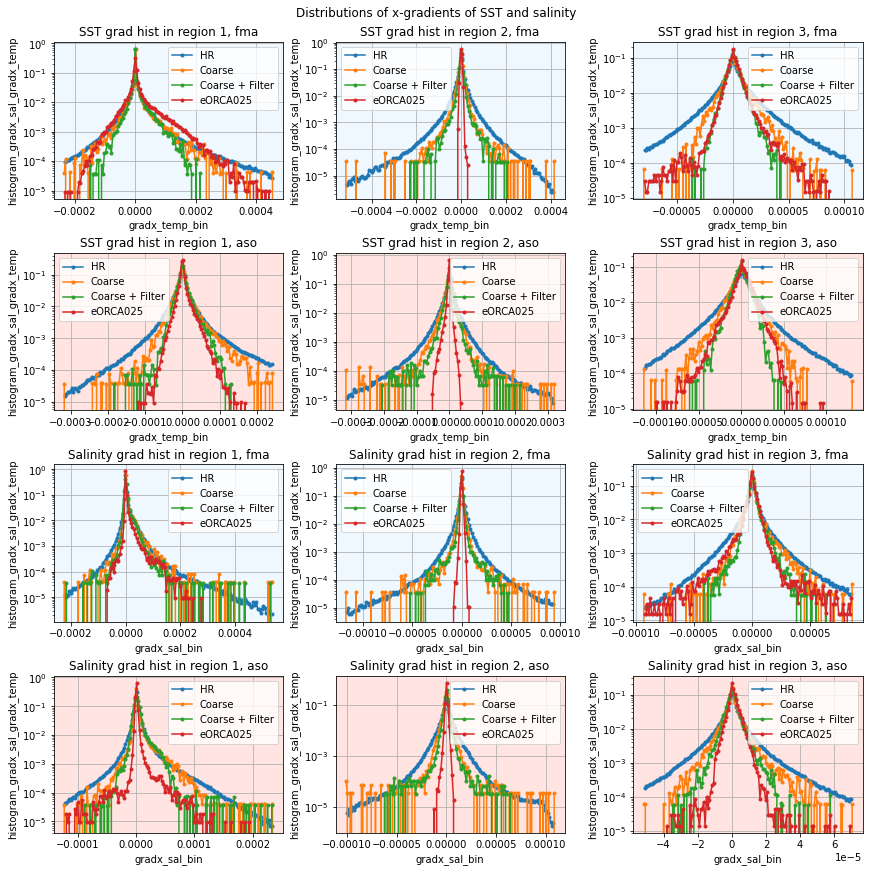

In [50]:
fig, ax = plt.subplots(ncols=3, nrows=4, constrained_layout=True, figsize=(12,12))
fig.suptitle('Distributions of x-gradients of SST and salinity')
for i in range(len(dataSetsLR)) :
    # temperature PDFs
    col = int(dataSetsLR[i]['region'])-1
    if (dataSetsLR[i]['season'] == 'aso') : 
        row=1; ax[row,col].set_facecolor('mistyrose')
    if (dataSetsLR[i]['season'] == 'fma') : 
        row=0; ax[row,col].set_facecolor('aliceblue')
    for dataSet in [dataSetsHR, dataSetsCoarse, dataSetsLR, dataSetsORCA25] :
        dataSet[i]['hist_grads_x'].sum(dim='gradx_sal_bin').plot(ax=ax[row,col], label=dataSet[i]['label'], ls='-', marker='.')
    ax[row,col].set(yscale='log', xscale='linear', title='SST grad hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)
    # salinity PDFs
    if (dataSetsLR[i]['season'] == 'aso') : 
        row=3; ax[row,col].set_facecolor('mistyrose')
    if (dataSetsLR[i]['season'] == 'fma') : 
        row=2; ax[row,col].set_facecolor('aliceblue')
    for dataSet in [dataSetsHR, dataSetsCoarse, dataSetsLR, dataSetsORCA25] :
        dataSet[i]['hist_grads_x'].sum(dim='gradx_temp_bin').plot(ax=ax[row,col], label=dataSet[i]['label'], ls='-', marker='.')
    ax[row,col].set(yscale='log', xscale='linear', title='Salinity grad hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)

## Y-direction gradients

In [51]:
%%time
for i in range(len(dataSetsLR)) :
    dataSetsCoarse[i]['hist_grads_y'] = compute_2D_histogram(dataSetsCoarse[i]['data'][bord_cut], 'grady_sal', 'grady_temp', nb_of_bins).compute()
for i in range(len(dataSetsLR)) :
    dataSetsHR[i]['hist_grads_y'] = compute_2D_histogram(dataSetsHR[i]['data'], 'grady_sal', 'grady_temp', nb_of_bins,\
                                                       bins=[dataSetsCoarse[i]['hist_grads_y'].grady_sal_bin.values,dataSetsCoarse[i]['hist_grads_y'].grady_temp_bin.values]).compute()
    dataSetsLR[i]['hist_grads_y'] = compute_2D_histogram(dataSetsLR[i]['data'], 'grady_sal', 'grady_temp', nb_of_bins,\
                                                       bins=[dataSetsCoarse[i]['hist_grads_y'].grady_sal_bin.values,dataSetsCoarse[i]['hist_grads_y'].grady_temp_bin.values]).compute()
    dataSetsORCA25[i]['hist_grads_y'] = compute_2D_histogram(dataSetsORCA25[i]['data'], 'grady_sal', 'grady_temp', nb_of_bins,\
                                                       bins=[dataSetsCoarse[i]['hist_grads_y'].grady_sal_bin.values,dataSetsCoarse[i]['hist_grads_y'].grady_temp_bin.values]).compute()

CPU times: user 1.63 s, sys: 164 ms, total: 1.79 s
Wall time: 6.02 s


Plot histograms for spatial gradients of SST and salinity in $y$-direction:
$$\partial_y T \approx \frac{T_{i, j+1} - T_{i, j}}{e2t} $$

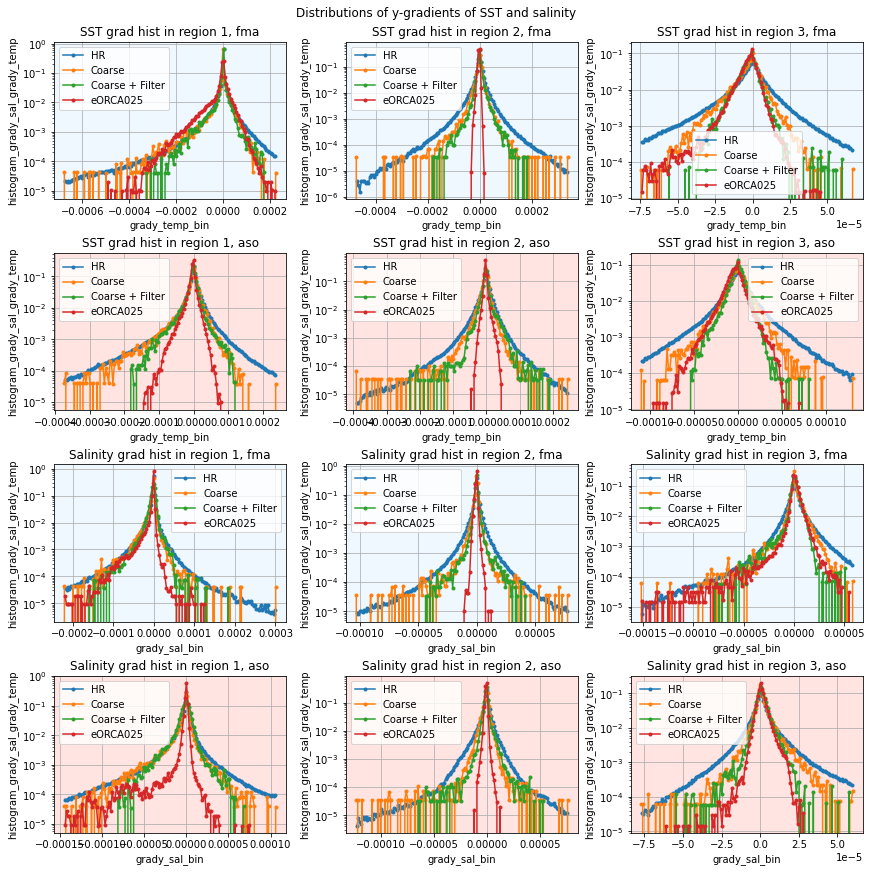

In [52]:
fig, ax = plt.subplots(ncols=3, nrows=4, constrained_layout=True, figsize=(12,12))
fig.suptitle('Distributions of y-gradients of SST and salinity')
for i in range(len(dataSetsLR)) :
    # temperature PDFs
    col = int(dataSetsLR[i]['region'])-1
    if (dataSetsLR[i]['season'] == 'aso') : 
        row=1; ax[row,col].set_facecolor('mistyrose')
    if (dataSetsLR[i]['season'] == 'fma') : 
        row=0; ax[row,col].set_facecolor('aliceblue')
    for dataSet in [dataSetsHR, dataSetsCoarse, dataSetsLR, dataSetsORCA25] :
        dataSet[i]['hist_grads_y'].sum(dim='grady_sal_bin').plot(ax=ax[row,col], label=dataSet[i]['label'], ls='-', marker='.')
    ax[row,col].set(yscale='log', xscale='linear', title='SST grad hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)
    # salinity PDFs
    if (dataSetsLR[i]['season'] == 'aso') : 
        row=3; ax[row,col].set_facecolor('mistyrose')
    if (dataSetsLR[i]['season'] == 'fma') : 
        row=2; ax[row,col].set_facecolor('aliceblue')
    for dataSet in [dataSetsHR, dataSetsCoarse, dataSetsLR, dataSetsORCA25] :
        dataSet[i]['hist_grads_y'].sum(dim='grady_temp_bin').plot(ax=ax[row,col], label=dataSet[i]['label'], ls='-', marker='.')
    ax[row,col].set(yscale='log', xscale='linear', title='Salinity grad hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)

# Statistical moments of x-direction gradients

## Temperature

In [53]:
keys = ['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']

In [54]:
%%time
for currentDataSet in (dataSetsHR+dataSetsORCA25+dataSetsCoarse+dataSetsLR) :
    currentDataSet['stat_temp_gradx'] = {}
    [currentDataSet['stat_temp_gradx']['nobs'], currentDataSet['stat_temp_gradx']['minmax'], currentDataSet['stat_temp_gradx']['mean'], \
     currentDataSet['stat_temp_gradx']['variance'], currentDataSet['stat_temp_gradx']['skewness'], currentDataSet['stat_temp_gradx']['kurtosis']] \
    = describe(currentDataSet['data'].gradx_temp, axis=None, nan_policy='omit')

CPU times: user 5.45 s, sys: 836 ms, total: 6.29 s
Wall time: 6.76 s


In [55]:
pd_stat_grads = dict()

In [56]:
pd_stat_grads['stat_temp_gradx'] = dict()
# organize the result in pandas table to simplify plotting
for dict_key in ['mean', 'variance', 'skewness', 'kurtosis'] :
    combine_table = {'Case':[curDataSet['region']+' '+curDataSet['season'] for curDataSet in dataSetsLR], \
                  'HR': [curDataSet['stat_temp_gradx'][dict_key] for curDataSet in dataSetsHR],\
                  'eORCA025': [curDataSet['stat_temp_gradx'][dict_key] for curDataSet in dataSetsORCA25],\
                  'Coarse': [curDataSet['stat_temp_gradx'][dict_key] for curDataSet in dataSetsCoarse],\
                  'LR': [curDataSet['stat_temp_gradx'][dict_key] for curDataSet in dataSetsLR]}
    pd_stat_grads['stat_temp_gradx'][dict_key] = pd.DataFrame(combine_table)

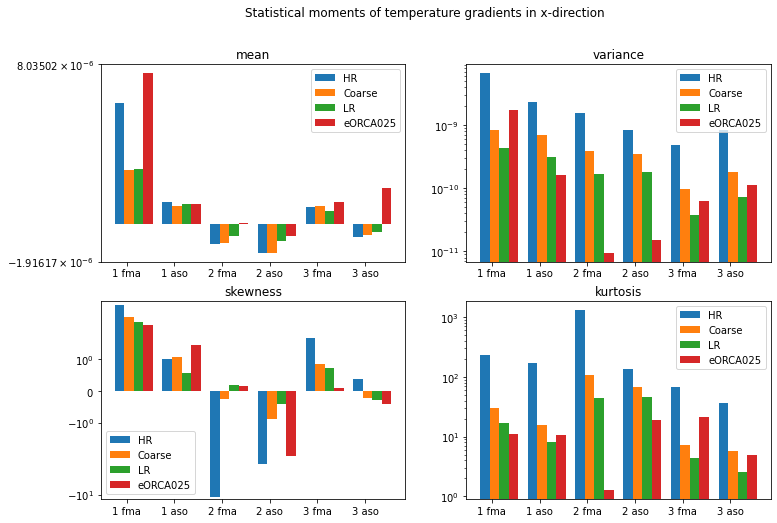

In [63]:
nb_of_rows = 2
nb_of_columns = 2
index_table = np.arange(2,6).reshape(2,2)

fig, ax = plt.subplots(nrows=nb_of_rows, ncols=nb_of_columns, figsize=(12, 8))
fig.suptitle('Statistical moments of temperature gradients in x-direction')
x = np.arange(len(pd_stat_grads['stat_temp_gradx']['mean'].Case.unique()))
bar_width = 0.2
for plot_index, key_index in np.ndenumerate(index_table) :
    dict_key = keys[key_index]
    b1 = ax[plot_index].bar(x, pd_stat_grads['stat_temp_gradx'][dict_key].HR, width=bar_width, label='HR')
    b2 = ax[plot_index].bar(x+bar_width, pd_stat_grads['stat_temp_gradx'][dict_key].Coarse, width=bar_width, label='Coarse')
    b3 = ax[plot_index].bar(x+2*bar_width, pd_stat_grads['stat_temp_gradx'][dict_key].LR, width=bar_width, label='LR')
    b4 = ax[plot_index].bar(x+3*bar_width, pd_stat_grads['stat_temp_gradx'][dict_key].eORCA025, width=bar_width, label='eORCA025')
    ax[plot_index].set_xticks(x + 0.75*bar_width)
    ax[plot_index].set_xticklabels(pd_stat_grads['stat_temp_gradx'][dict_key].Case.unique())
    if (plot_index[1]== 1) : ax[plot_index].set(title=dict_key, yscale='log')
    if (plot_index[1]== 0) : ax[plot_index].set(title=dict_key, yscale='symlog')
    ax[plot_index].legend()
plt.show()

## Salinity

In [64]:
%%time
for currentDataSet in (dataSetsHR+dataSetsORCA25+dataSetsCoarse+dataSetsLR) :
    currentDataSet['stat_sal_gradx'] = {}
    current_dictionary = currentDataSet['stat_sal_gradx']
    [current_dictionary['nobs'], current_dictionary['minmax'], current_dictionary['mean'], \
     current_dictionary['variance'], current_dictionary['skewness'], current_dictionary['kurtosis']] \
    = describe(currentDataSet['data'].gradx_sal, axis=None, nan_policy='omit')

CPU times: user 5.58 s, sys: 880 ms, total: 6.46 s
Wall time: 6.96 s


In [65]:
pd_stat_grads['stat_sal_gradx'] = dict()
# organize the result in pandas table to simplify plotting
for dict_key in ['mean', 'variance', 'skewness', 'kurtosis'] :
    cur_stat_key = 'stat_sal_gradx'
    combine_table = {'Case':[curDataSet['region']+' '+curDataSet['season'] for curDataSet in dataSetsLR], \
                  'HR': [curDataSet[cur_stat_key][dict_key] for curDataSet in dataSetsHR],\
                  'eORCA025': [curDataSet[cur_stat_key][dict_key] for curDataSet in dataSetsORCA25],\
                  'Coarse': [curDataSet[cur_stat_key][dict_key] for curDataSet in dataSetsCoarse],\
                  'LR': [curDataSet[cur_stat_key][dict_key] for curDataSet in dataSetsLR]}
    pd_stat_grads[cur_stat_key][dict_key] = pd.DataFrame(combine_table)

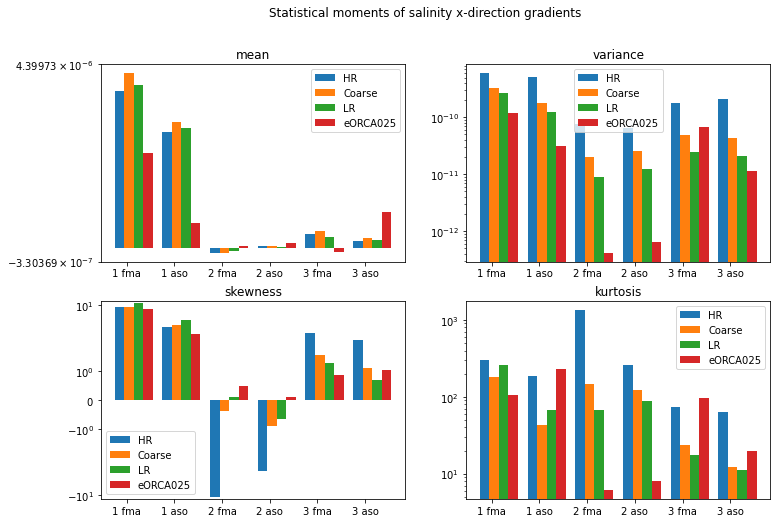

In [67]:
nb_of_rows = 2
nb_of_columns = 2
index_table = np.arange(2,6).reshape(2,2)

fig, ax = plt.subplots(nrows=nb_of_rows, ncols=nb_of_columns, figsize=(12, 8))
fig.suptitle('Statistical moments of salinity x-direction gradients')
x = np.arange(len(pd_stat_grads[cur_stat_key]['mean'].Case.unique()))
bar_width = 0.2
for plot_index, key_index in np.ndenumerate(index_table) :
    dict_key = keys[key_index]
    cur_stat_key = 'stat_sal_gradx'
    b1 = ax[plot_index].bar(x, pd_stat_grads[cur_stat_key][dict_key].HR, width=bar_width, label='HR')
    b2 = ax[plot_index].bar(x+bar_width, pd_stat_grads[cur_stat_key][dict_key].Coarse, width=bar_width, label='Coarse')
    b3 = ax[plot_index].bar(x+2*bar_width, pd_stat_grads[cur_stat_key][dict_key].LR, width=bar_width, label='LR')
    b4 = ax[plot_index].bar(x+3*bar_width, pd_stat_grads[cur_stat_key][dict_key].eORCA025, width=bar_width, label='eORCA025')
    ax[plot_index].set_xticks(x + 0.75*bar_width)
    ax[plot_index].set_xticklabels(pd_stat_grads[cur_stat_key][dict_key].Case.unique())
    if (plot_index[1]== 1) : ax[plot_index].set(title=dict_key, yscale='log')
    if (plot_index[1]== 0) : ax[plot_index].set(title=dict_key, yscale='symlog')
    ax[plot_index].legend()
plt.show()

# Structure functions of SST (x-direction)

## Compute

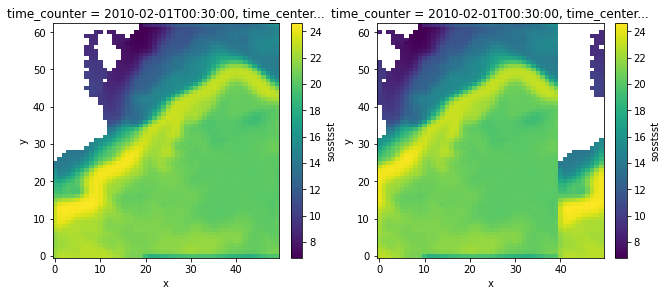

In [68]:
fig, ax = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9,4))
dataArrayToShow = dataSetsLR[0]['data'].isel(time_counter=0).sosstsst
dataArrayToShow.plot(ax=ax[0])
dataArrayToShow.roll(x=-10,roll_coords=False).plot(ax=ax[1])
plt.show()

In [69]:
def compute_structure_functions(dataArr, key_field) :
    N = len(dataArr['x'])
    vectorS1 = np.zeros(N//2-1)
    vectorS2 = np.zeros(N//2-1)
    vectorS3 = np.zeros(N//2-1)
    distance = np.zeros(N//2-1)
    for index,index_shift in enumerate(range(1,N//2)) :
        cut=slice(1,N-index_shift)
        shiftedArr = dataArr[key_field].roll(x=-index_shift,roll_coords=False)
        difference = dataArr[key_field][cut] - shiftedArr[cut]
        vectorS1[index] = difference.mean().values
        vectorS2[index] = (difference**2).mean().values
        vectorS3[index] = (difference**3).mean().values
        distance[index] = dataArr.isel(x=slice(0,index_shift)).e1t.sum(dim='x').mean(dim='y').values
    stucture_functions_dataset = xr.Dataset(data_vars={'S1' : xr.DataArray(vectorS1, dims=["shift"]),\
                                             'S2' : xr.DataArray(vectorS2, dims=["shift"]),\
                                             'S3' : xr.DataArray(vectorS3, dims=["shift"])}, \
                                            coords={'shift' : np.arange(1,N//2),\
                                                   'shift_distance' : ('shift', distance/1000)})
    return stucture_functions_dataset

In [70]:
%%time 
for currentDataSet in (dataSetsLR+dataSetsCoarse+dataSetsORCA25) :
    currentDataSet['temp_str_fun'] = compute_structure_functions(currentDataSet['data'],'sosstsst')

CPU times: user 24.3 s, sys: 870 ms, total: 25.2 s
Wall time: 1min 43s


In [71]:
# %%time 
# for currentDataSet in (dataSetsHR) :
#     currentDataSet['temp_str_fun'] = compute_structure_functions(currentDataSet['data'],'sosstsst')

In [76]:
%%time 
for currentDataSet in (dataSetsHR) :
    currentDataSet['temp_str_fun'] = xr.open_dataset("../Data/Compare_histograms/temp_str_fun_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")

CPU times: user 29.7 ms, sys: 1.47 ms, total: 31.1 ms
Wall time: 174 ms


## Plot

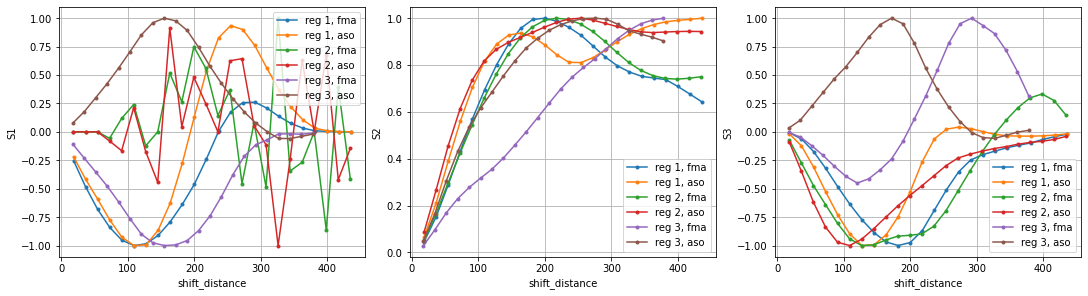

In [77]:
fig, ax = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15,4))
for index, data_key in enumerate(['S1', 'S2', 'S3']) :
    for currentDataSet in (dataSetsLR) :
        data_to_plot = currentDataSet['temp_str_fun'][data_key]
        data_to_plot = data_to_plot/(np.abs(data_to_plot).max())
        data_to_plot.plot(ax=ax[index], x='shift_distance', label='reg '+currentDataSet['region']+', '+currentDataSet['season'], \
                                  marker='.')
    ax[index].set(yscale='linear', xscale='linear'); ax[index].grid(True)
    ax[index].legend()
plt.show()

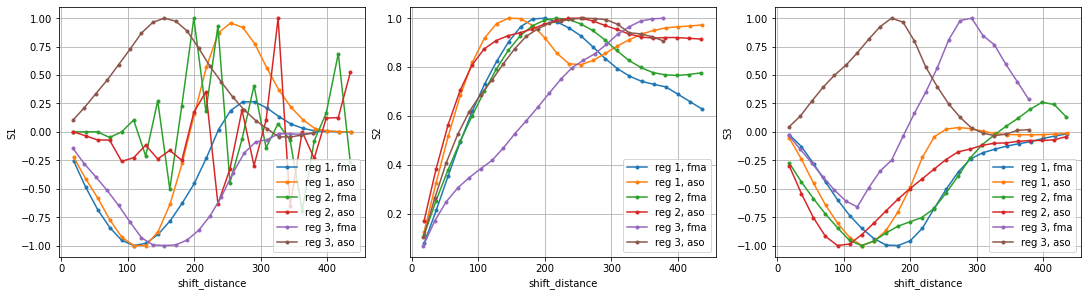

In [78]:
fig, ax = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15,4))
for index, data_key in enumerate(['S1', 'S2', 'S3']) :
    for currentDataSet in (dataSetsCoarse) :
        data_to_plot = currentDataSet['temp_str_fun'][data_key]
        data_to_plot = data_to_plot/(np.abs(data_to_plot).max())
        data_to_plot.plot(ax=ax[index], x='shift_distance', label='reg '+currentDataSet['region']+', '+currentDataSet['season'], \
                                  marker='.')
    ax[index].set(yscale='linear', xscale='linear'); ax[index].grid(True)
    ax[index].legend()
plt.show()

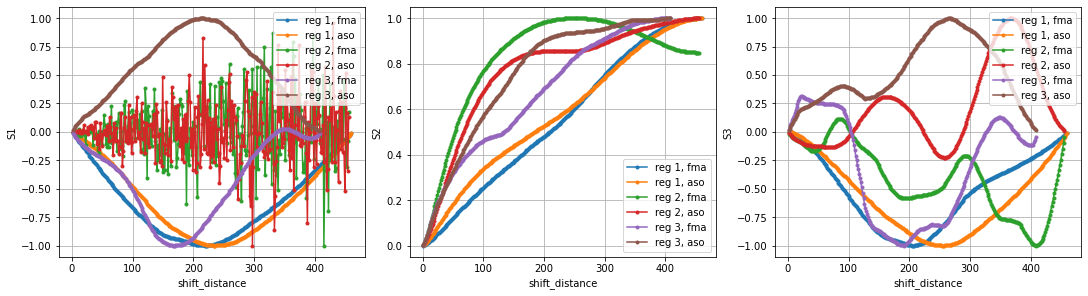

In [79]:
fig, ax = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15,4))
for index, data_key in enumerate(['S1', 'S2', 'S3']) :
    for currentDataSet in (dataSetsHR) :
        data_to_plot = currentDataSet['temp_str_fun'][data_key]
        data_to_plot = data_to_plot/(np.abs(data_to_plot).max())
        data_to_plot.plot(ax=ax[index], x='shift_distance', label='reg '+currentDataSet['region']+', '+currentDataSet['season'], \
                                  marker='.')
    ax[index].set(yscale='linear', xscale='linear'); ax[index].grid(True)
    ax[index].legend()
plt.show()

## Compare

Second order structure functions of SST normalized by variance:
$$ S_2 (l) = \frac{\langle[T(x+l) - T(x)]^2 \rangle}{\textrm{var}(T)} $$

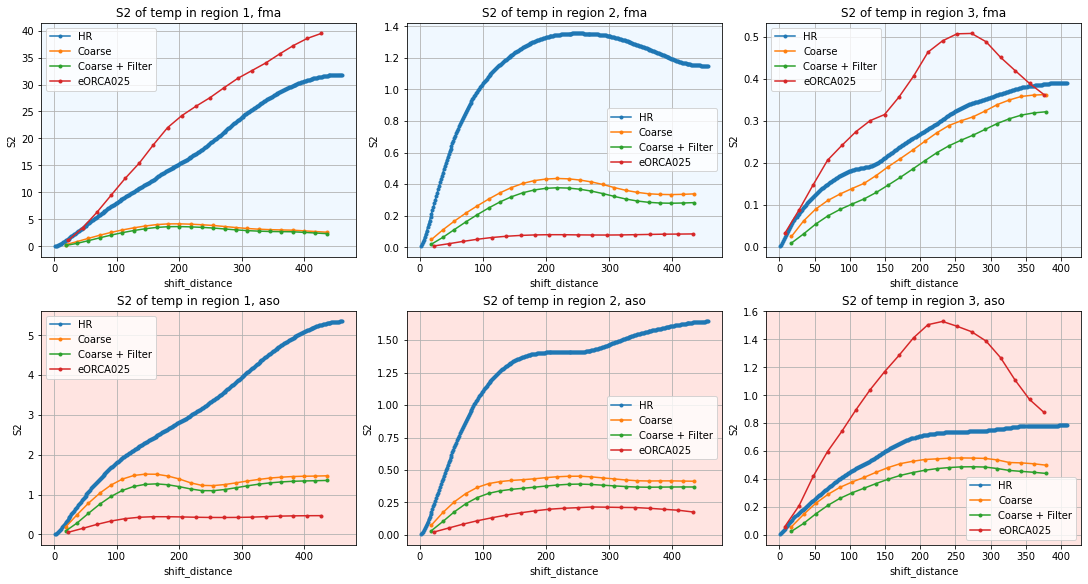

In [80]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
for i in range(len(dataSetsLR)) :
    col = int(dataSetsLR[i]['region'])-1
    if (dataSetsLR[i]['season'] == 'aso') : 
        row=1; ax[row,col].set_facecolor('mistyrose')
    if (dataSetsLR[i]['season'] == 'fma') : 
        row=0; ax[row,col].set_facecolor('aliceblue')
    for dataSet in [dataSetsHR, dataSetsCoarse, dataSetsLR, dataSetsORCA25] :
        data = dataSet[i]['temp_str_fun']['S2']
        normalization = (dataSet[i]['data']['sosstsst']).var().values
        #data_to_plot = data/normalization
        data.plot(x='shift_distance', ax=ax[row,col], label=dataSet[i]['label'], ls='-', marker='.')
    ax[row,col].set(yscale='linear', xscale='linear', title='S2 of temp in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)   

In [ ]:
## Write
# for currentDataSet in (dataSetsHR) :
#     currentDataSet['temp_str_fun'].to_netcdf("Data/Compare_histograms/temp_str_fun_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")